In [1]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'maritime_museum'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

00:02:52 - INFO - Label maritime_museum does not currently have extracted meshes. Attempting now.
00:02:52 - INFO - Cleaning .bin extraction dirs.
00:02:52 - INFO - Splitting bin file ../../data/meshes/extracted/maritime_museum/maritime_museum.bin by category...
00:02:52 - INFO -   extracting category: 1_WALL
00:02:53 - INFO -   extracting category: 2_FLOOR
00:02:54 - INFO -   extracting category: 3_ROOF
00:02:55 - INFO -   extracting category: 4_CEILING
00:02:56 - INFO -   extracting category: 5_FOOTPATH
00:02:58 - INFO -   extracting category: 6_GRASS
00:02:59 - INFO -   extracting category: 7_COLUMN
00:03:00 - INFO -   extracting category: 8_DOOR
00:03:01 - INFO -   extracting category: 9_WINDOW
00:03:02 - INFO -   extracting category: 10_STAIR
00:03:04 - INFO -   extracting category: 11_RAILING
00:03:05 - INFO -   extracting category: 12_RWP
00:03:05 - INFO -   extracting category: 13_OTHER
00:03:07 - INFO -   converting 1_wall.bin
00:03:07 - INFO -   converting 2_floor.bin
00:03:0

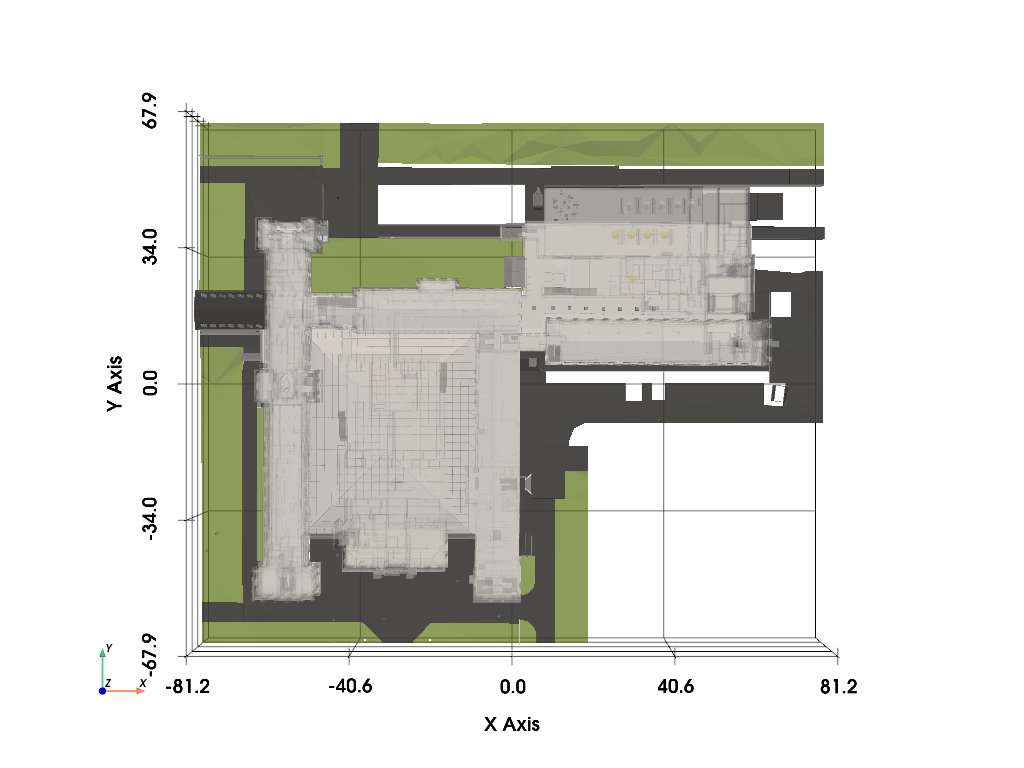

In [3]:
dh.plot_meshes()

In [4]:
analyser = MeshAnalyser(data_handler=dh)

In [5]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

00:03:30 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '13_OTHER'].
00:03:30 - INFO - Sampling with resolution 0.15.
00:03:30 - INFO - Number of points after initial sampling: 22497028
00:03:43 - INFO - Number of points after Poisson Disk Sampling: 2113517
00:03:43 - INFO - Number of points after initial sampling: 7294249
00:03:48 - INFO - Number of points after Poisson Disk Sampling: 1568578
00:03:49 - INFO - Number of points after initial sampling: 4012966
00:03:50 - INFO - Number of points after Poisson Disk Sampling: 339537
00:03:50 - INFO - Number of points after initial sampling: 8835305
00:03:54 - INFO - Number of points after Poisson Disk Sampling: 566336
00:03:54 - INFO - Number of points after initial sampling: 2095338
00:03:56 - INFO - Number of points after Poisson Disk Sampling: 458238
00:03:56 - INFO - Number of points after initial sampli

In [6]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

00:04:00 - INFO - Binning is using 28 bins in X and 23 bins in Y based on cell widths of 6.0 and 6.0.


00:18:02 - INFO - New best equality score: 465456468836164352.0000 at iteration 1
00:18:02 - INFO - New best equality score: 43317661.3857 at iteration 4
00:18:02 - INFO - New best equality score: 362366.6062 at iteration 7
00:18:03 - INFO - New best equality score: 182884.2793 at iteration 8
00:18:03 - INFO - New best equality score: 142641.1982 at iteration 25
00:18:04 - INFO - New best equality score: 138727.2985 at iteration 44
00:18:05 - INFO - Number of unique seed cell configurations = 100


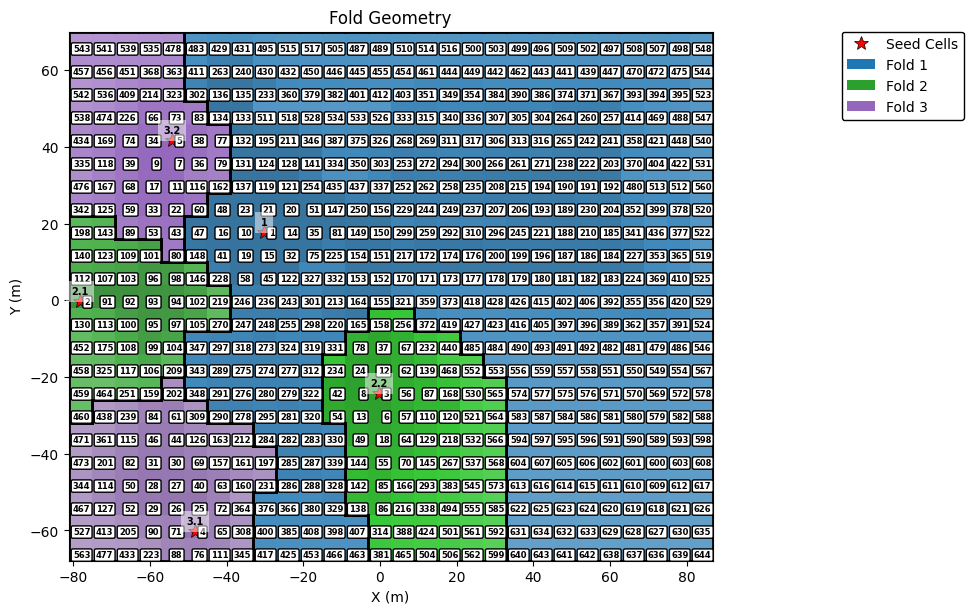

Iteration: 44

Fold Summaries:

Fold 1:
  Intended total counts: 3374941.20
  Actual total counts: 3378960.0
  Category Counts:
    1_WALL: 1237849.0 (58.57% of total 1_WALL)
    2_FLOOR: 1028279.0 (65.55% of total 2_FLOOR)
    3_ROOF: 188979.0 (55.66% of total 3_ROOF)
    4_CEILING: 352737.0 (62.28% of total 4_CEILING)
    5_FOOTPATH: 271601.0 (59.27% of total 5_FOOTPATH)
    6_GRASS: 81124.0 (45.76% of total 6_GRASS)
    7_COLUMN: 36214.0 (44.86% of total 7_COLUMN)
    8_DOOR: 30699.0 (52.75% of total 8_DOOR)
    9_WINDOW: 27507.0 (47.74% of total 9_WINDOW)
    10_STAIR: 30112.0 (62.22% of total 10_STAIR)
    11_RAILING: 23080.0 (66.21% of total 11_RAILING)
    13_OTHER: 70779.0 (58.20% of total 13_OTHER)
  Aspect Ratio: 1.00

Fold 2:
  Intended total counts: 1124980.40
  Actual total counts: 1174582.0
  Category Counts:
    1_WALL: 441423.0 (20.89% of total 1_WALL)
    2_FLOOR: 317547.0 (20.24% of total 2_FLOOR)
    3_ROOF: 86486.0 (25.47% of total 3_ROOF)
    4_CEILING: 121445.0 (2

In [19]:
weights = {1: 0.6, 2: 0.2, 3: 0.2}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 2, 3: 2}
iterations = 100  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 6.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

00:18:28 - INFO - Fold 1, Region 1: Found 20 rectangles with total perimeter 252


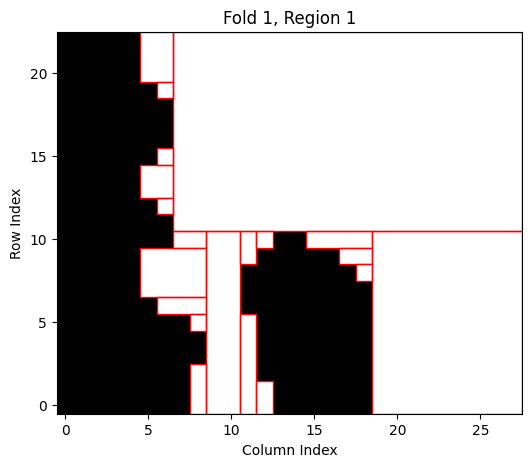

00:18:28 - INFO - Fold 2, Region 2: Found 6 rectangles with total perimeter 54


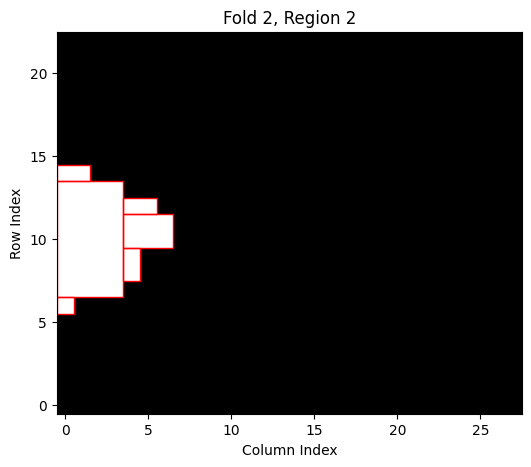

00:18:28 - INFO - Fold 2, Region 3: Found 6 rectangles with total perimeter 74


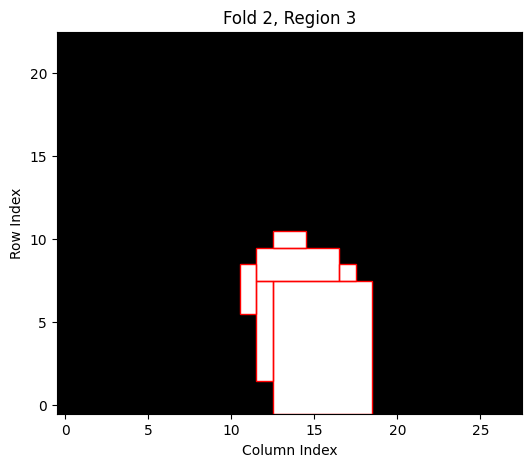

00:18:28 - INFO - Fold 3, Region 4: Found 4 rectangles with total perimeter 50


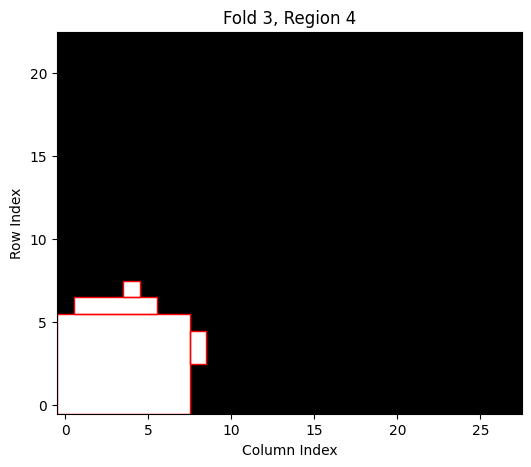

00:18:29 - INFO - Fold 3, Region 5: Found 6 rectangles with total perimeter 56


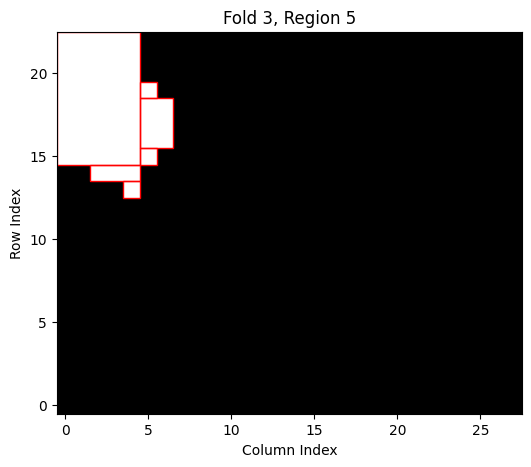

In [20]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [21]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

00:18:38 - INFO - Processing Region 1 in Fold 1
00:20:34 - INFO - Processing Region 2 in Fold 2
00:21:35 - INFO - Processing Region 3 in Fold 2
00:22:03 - INFO - Processing Region 4 in Fold 3
00:22:46 - INFO - Processing Region 5 in Fold 3


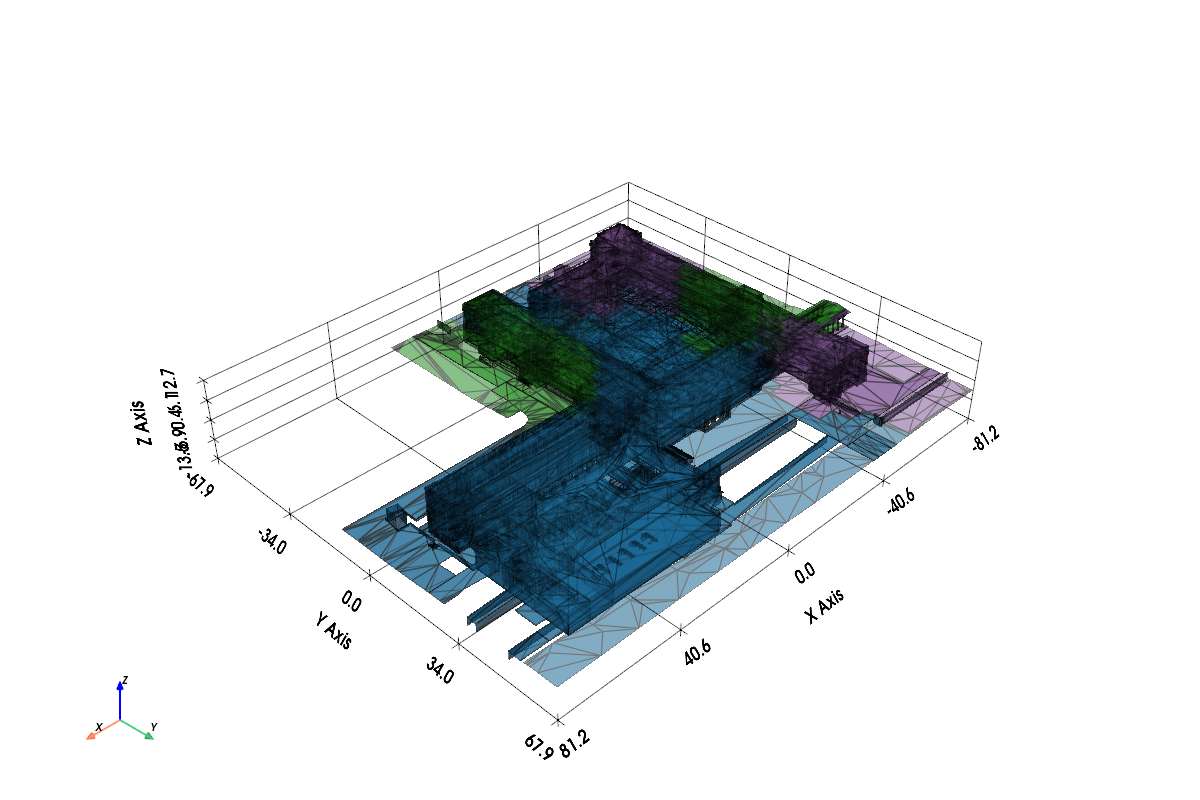

In [24]:
plot_mesh_folds(fold_meshes, backend='static', cmap='tab20')

In [25]:
best_config.save(f"../../fold_allocations/{label}_v1.pkl")

In [26]:
save_fold_meshes(dh, fold_meshes)

00:25:18 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/maritime_museum/train/1_wall_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/maritime_museum/train/2_floor_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/maritime_museum/train/3_roof_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/maritime_museum/train/4_ceiling_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '5_FOOTPATH' to ../../data/meshes/extracted/maritime_museum/train/5_footpath_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '6_GRASS' to ../../data/meshes/extracted/maritime_museum/train/6_grass_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/maritime_museum/train/7_column_sceneid1.ply.
00:25:18 - INFO - Saved Fold 1, Region 1